
Example 1: Classic Eden with central seed...
Saved to eden_temporal_classic.png


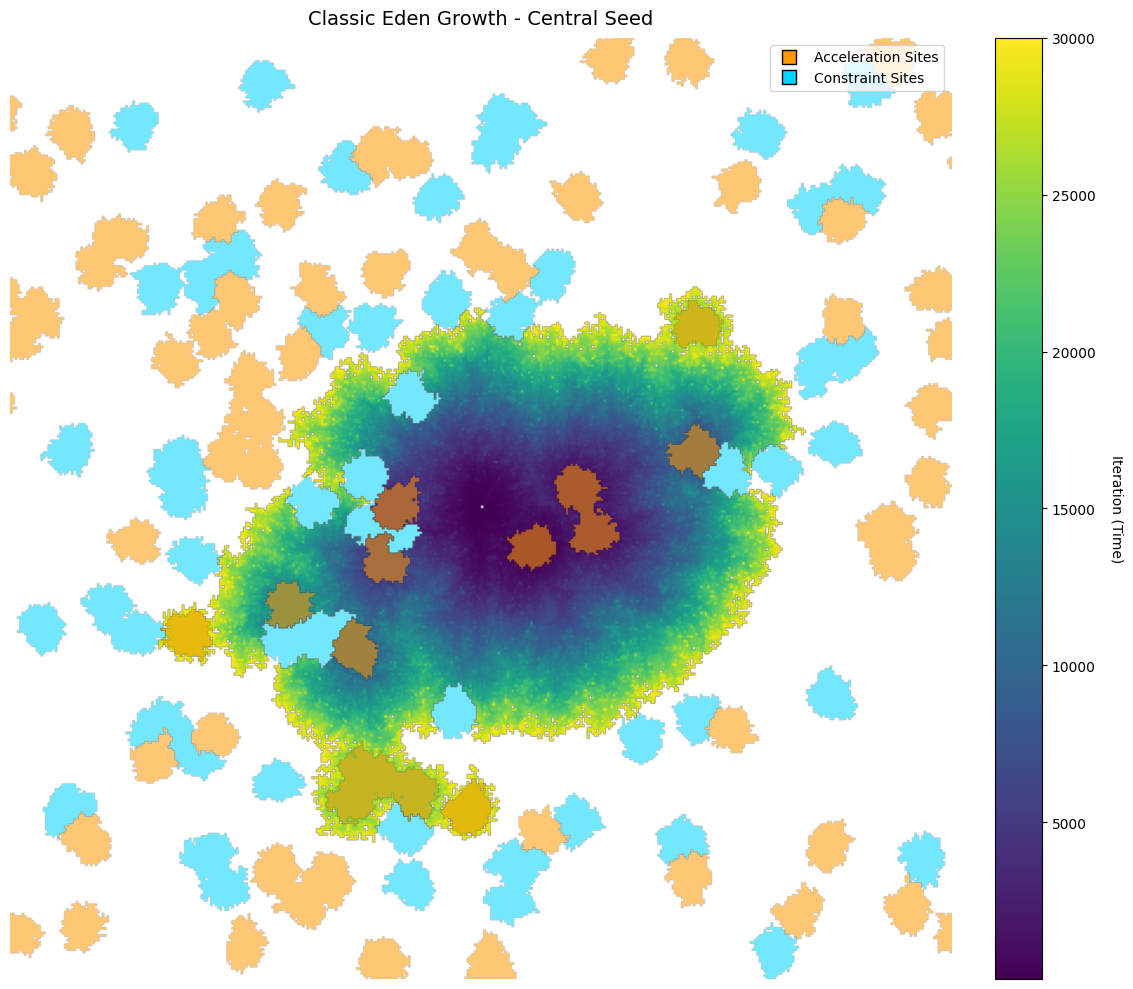

In [15]:
import numpy as np
from numba import jit, prange
from numba.typed import List
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# ============================================================================
# INITIALIZATION FUNCTIONS
# ============================================================================
@jit(nopython=True)
def initialize_flat(width, height):
    """Initialize with flat bottom row."""
    lattice = np.zeros((height, width), dtype=np.int32)
    lattice[-1, :] = 1
    return lattice

@jit(nopython=True)
def initialize_central_seed(width, height):
    """Initialize with a single seed in the center."""
    lattice = np.zeros((height, width), dtype=np.int32)
    center_i = height // 2
    center_j = width // 2
    lattice[center_i, center_j] = 1
    return lattice

@jit(nopython=True)
def initialize_rough(width, height, roughness_height, seed=None):
    """Initialize with random roughness on top of bottom row."""
    if seed is not None:
        np.random.seed(seed)
    lattice = np.zeros((height, width), dtype=np.int32)
    for j in range(width):
        h = np.random.randint(1, roughness_height + 1)
        for i in range(height - h, height):
            lattice[i, j] = 1
    return lattice

# ============================================================================
# CLUSTER PLACEMENT WITH RUGOSITY CONTROL
# ============================================================================
@jit(nopython=True)
def place_clusters_with_labels(width, height, avg_cluster_size, probability, lattice, seed=None):
    """Place clusters and label each site with its cluster ID."""
    if seed is not None:
        np.random.seed(seed)
    acc_sites = np.zeros((height, width), dtype=np.int32)
    cluster_labels = np.zeros((height, width), dtype=np.int32)
    cluster_list = List()
    cluster_list.append(np.zeros((0, 2), dtype=np.int32))
    cluster_id = 1
    max_cluster_size = avg_cluster_size * 10
    
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                cluster_positions = np.zeros((max_cluster_size, 2), dtype=np.int32)
                cluster_positions[0, 0] = i
                cluster_positions[0, 1] = j
                acc_sites[i, j] = 1
                cluster_labels[i, j] = cluster_id
                placed = 1
                
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts = 0
                boundary_count = 1
                center_i = float(i)
                center_j = float(j)
                max_attempts = cluster_size * 10
                
                while placed < cluster_size and attempts < max_attempts and boundary_count > 0:
                    attempts += 1
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        if 0 <= ni < height and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        
                        acc_sites[ni, nj] = 1
                        cluster_labels[ni, nj] = cluster_id
                        cluster_positions[placed, 0] = ni
                        cluster_positions[placed, 1] = nj
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        boundary_count += 1
                        placed += 1
                        
                        center_i = (center_i * (placed - 1) + ni) / placed
                        center_j = (center_j * (placed - 1) + nj) / placed
                
                cluster_positions_actual = cluster_positions[:placed].copy()
                cluster_list.append(cluster_positions_actual)
                cluster_id += 1
    
    if cluster_id > 1:
        parent = np.arange(cluster_id, dtype=np.int32)
        rank = np.zeros(cluster_id, dtype=np.int32)
        
        def find(x):
            root = x
            while parent[root] != root:
                root = parent[root]
            while x != root:
                nxt = parent[x]
                parent[x] = root
                x = nxt
            return root
        
        def union(x, y):
            px = find(x)
            py = find(y)
            if px != py:
                if rank[px] > rank[py]:
                    parent[py] = px
                elif rank[px] < rank[py]:
                    parent[px] = py
                else:
                    parent[py] = px
                    rank[px] += 1
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    nj_right = (jj + 1) % width
                    if cluster_labels[ii, nj_right] > 0 and cluster_labels[ii, jj] != cluster_labels[ii, nj_right]:
                        union(cluster_labels[ii, jj], cluster_labels[ii, nj_right])
                    if ii + 1 < height and cluster_labels[ii + 1, jj] > 0 and cluster_labels[ii, jj] != cluster_labels[ii + 1, jj]:
                        union(cluster_labels[ii, jj], cluster_labels[ii + 1, jj])
        
        for k in range(1, cluster_id):
            parent[k] = find(k)
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = parent[cluster_labels[ii, jj]]
        
        has_label = np.zeros(cluster_id, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    has_label[lbl] = 1
        
        new_num_clusters = 0
        label_map = np.zeros(cluster_id, dtype=np.int32)
        for lbl in range(1, cluster_id):
            if has_label[lbl] == 1:
                new_num_clusters += 1
                label_map[lbl] = new_num_clusters
        
        for ii in range(height):
            for jj in range(width):
                if cluster_labels[ii, jj] > 0:
                    cluster_labels[ii, jj] = label_map[cluster_labels[ii, jj]]
        
        sizes = np.zeros(new_num_clusters + 1, dtype=np.int32)
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    sizes[lbl] += 1
        
        new_cluster_list = List()
        new_cluster_list.append(np.zeros((0, 2), dtype=np.int32))
        counters = np.zeros(new_num_clusters + 1, dtype=np.int32)
        
        for new_id in range(1, new_num_clusters + 1):
            pos = np.zeros((sizes[new_id], 2), dtype=np.int32)
            new_cluster_list.append(pos)
        
        for ii in range(height):
            for jj in range(width):
                lbl = cluster_labels[ii, jj]
                if lbl > 0:
                    pos = new_cluster_list[lbl]
                    idx = counters[lbl]
                    pos[idx, 0] = ii
                    pos[idx, 1] = jj
                    counters[lbl] += 1
        
        cluster_list = new_cluster_list
    
    return acc_sites, cluster_labels, cluster_list

@jit(nopython=True)
def place_constraint_clusters(width, height, avg_cluster_size, probability, lattice, acc_sites, seed=None):
    """Place constraint clusters."""
    if seed is not None:
        np.random.seed(seed)
    con_sites = np.zeros((height, width), dtype=np.int32)
    max_cluster_size = avg_cluster_size * 10
    
    for i in range(height):
        for j in range(width):
            if np.random.random() < probability and con_sites[i, j] == 0 and acc_sites[i, j] == 0 and lattice[i, j] == 0:
                cluster_size = max(1, int(avg_cluster_size + np.random.randn() * np.sqrt(float(avg_cluster_size))))
                placed = 1
                con_sites[i, j] = 1
                
                cluster_i = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_j = np.zeros(max_cluster_size, dtype=np.int32)
                cluster_i[0] = i
                cluster_j[0] = j
                cluster_count = 1
                attempts = 0
                max_attempts = cluster_size * 10
                
                while placed < cluster_size and attempts < max_attempts:
                    idx = np.random.randint(0, cluster_count)
                    ci = cluster_i[idx]
                    cj = cluster_j[idx]
                    
                    neighbor_i = np.array([ci-1, ci+1, ci, ci], dtype=np.int32)
                    neighbor_j = np.array([cj, cj, cj-1, cj+1], dtype=np.int32)
                    available = np.zeros(4, dtype=np.int32)
                    n_available = 0
                    
                    for n_idx in range(4):
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        if 0 <= ni < height and con_sites[ni, nj] == 0 and acc_sites[ni, nj] == 0 and lattice[ni, nj] == 0:
                            available[n_available] = n_idx
                            n_available += 1
                    
                    if n_available > 0:
                        pick = np.random.randint(0, n_available)
                        n_idx = available[pick]
                        ni = neighbor_i[n_idx]
                        nj = neighbor_j[n_idx] % width
                        
                        con_sites[ni, nj] = 1
                        cluster_i[cluster_count] = ni
                        cluster_j[cluster_count] = nj
                        cluster_count += 1
                        placed += 1
                    
                    attempts += 1
    
    return con_sites

# ============================================================================
# EDEN MODEL WITH TEMPORAL TRACKING
# ============================================================================

def eden_model_with_temporal(width, height, n_iterations, 
                             init_mode='central', roughness_height=5,
                             avg_cluster_size=5, probability=0.01,
                             acceleration_factor=2.0,
                             constraint_prob=0.0,
                             constraint_avg_cluster_size=5,
                             periodic_horizontal=True, periodic_vertical=False,
                             seed=None):
    """
    Eden model that tracks when each site was occupied (for temporal visualization).
    
    Returns:
    --------
    temporal_map : numpy.ndarray
        Array where each site's value is the iteration when it was occupied (0 = never)
    acc_sites : numpy.ndarray
        Acceleration cluster sites
    con_sites : numpy.ndarray
        Constraint cluster sites
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Initialize lattice
    if init_mode == 'central':
        lattice = initialize_central_seed(width, height)
    elif init_mode == 'rough':
        lattice = initialize_rough(width, height, roughness_height, seed)
    else:
        lattice = initialize_flat(width, height)
    
    # Temporal map: records the iteration when each site was occupied
    temporal_map = np.zeros((height, width), dtype=np.int32)
    # Mark initial sites with iteration 0
    temporal_map[lattice == 1] = 0
    
    # Place acceleration and constraint clusters
    acc_sites, cluster_labels, cluster_list = place_clusters_with_labels(
        width, height, avg_cluster_size, probability, lattice, seed
    )
    
    con_sites = place_constraint_clusters(
        width, height, constraint_avg_cluster_size, constraint_prob, 
        lattice, acc_sites, seed
    )
    
    n_clusters = len(cluster_list)
    cluster_activated = np.zeros(n_clusters, dtype=np.int32)
    
    # Initialize boundary tracking
    is_boundary = np.zeros((height, width), dtype=np.int32)
    max_boundary_size = width * height
    boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    boundary_count = 0
    
    acc_boundary_i = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_j = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_cluster = np.zeros(max_boundary_size, dtype=np.int32)
    acc_boundary_count = 0
    
    # Find initial boundary sites
    for i in range(height):
        for j in range(width):
            if lattice[i, j] == 0 and con_sites[i, j] == 0:
                has_occupied = False
                
                for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni = i + dni
                    nj = j + dnj
                    
                    if periodic_vertical:
                        ni = ni % height
                    if periodic_horizontal:
                        nj = nj % width
                    
                    valid = True
                    if not periodic_vertical and (ni < 0 or ni >= height):
                        valid = False
                    if not periodic_horizontal and (nj < 0 or nj >= width):
                        valid = False
                    
                    if valid and lattice[ni, nj] == 1:
                        has_occupied = True
                        break
                
                if has_occupied:
                    is_boundary[i, j] = 1
                    cell_cluster = cluster_labels[i, j]
                    
                    if cell_cluster > 0 and cluster_activated[cell_cluster] == 0:
                        already_in = False
                        for k in range(acc_boundary_count):
                            if acc_boundary_cluster[k] == cell_cluster:
                                already_in = True
                                break
                        if not already_in:
                            acc_boundary_i[acc_boundary_count] = i
                            acc_boundary_j[acc_boundary_count] = j
                            acc_boundary_cluster[acc_boundary_count] = cell_cluster
                            acc_boundary_count += 1
                    else:
                        boundary_i[boundary_count] = i
                        boundary_j[boundary_count] = j
                        boundary_count += 1
    
    # Growth iterations with temporal tracking
    for iteration in range(1, n_iterations + 1):
        total_boundary = boundary_count + acc_boundary_count
        if total_boundary == 0:
            break
        
        # Weighted selection
        total_weight = boundary_count + acc_boundary_count * acceleration_factor
        rand_val = np.random.random() * total_weight
        
        if rand_val < acc_boundary_count * acceleration_factor and acc_boundary_count > 0:
            # CASCADE: Select acceleration cluster
            idx = np.random.randint(0, acc_boundary_count)
            selected_cluster = acc_boundary_cluster[idx]
            cluster_sites = cluster_list[selected_cluster]
            
            # Occupy entire cluster and record time
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                lattice[ci, cj] = 1
                temporal_map[ci, cj] = iteration
                is_boundary[ci, cj] = 0
            
            cluster_activated[selected_cluster] = 1
            
            # Remove from acceleration boundary
            acc_boundary_count -= 1
            if idx < acc_boundary_count:
                acc_boundary_i[idx] = acc_boundary_i[acc_boundary_count]
                acc_boundary_j[idx] = acc_boundary_j[acc_boundary_count]
                acc_boundary_cluster[idx] = acc_boundary_cluster[acc_boundary_count]
            
            # Add neighbors
            for k in range(len(cluster_sites)):
                ci, cj = cluster_sites[k, 0], cluster_sites[k, 1]
                
                for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni = ci + dni
                    nj = cj + dnj
                    
                    if periodic_vertical:
                        ni = ni % height
                    if periodic_horizontal:
                        nj = nj % width
                    
                    valid = True
                    if not periodic_vertical and (ni < 0 or ni >= height):
                        valid = False
                    if not periodic_horizontal and (nj < 0 or nj >= width):
                        valid = False
                    
                    if valid and lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                        has_occ = False
                        for dni2, dnj2 in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nni = ni + dni2
                            nnj = nj + dnj2
                            
                            if periodic_vertical:
                                nni = nni % height
                            if periodic_horizontal:
                                nnj = nnj % width
                            
                            check_valid = True
                            if not periodic_vertical and (nni < 0 or nni >= height):
                                check_valid = False
                            if not periodic_horizontal and (nnj < 0 or nnj >= width):
                                check_valid = False
                            
                            if check_valid and lattice[nni, nnj] == 1:
                                has_occ = True
                                break
                        
                        if has_occ:
                            is_boundary[ni, nj] = 1
                            nc = cluster_labels[ni, nj]
                            
                            if nc > 0 and cluster_activated[nc] == 0:
                                already = False
                                for m in range(acc_boundary_count):
                                    if acc_boundary_cluster[m] == nc:
                                        already = True
                                        break
                                if not already:
                                    acc_boundary_i[acc_boundary_count] = ni
                                    acc_boundary_j[acc_boundary_count] = nj
                                    acc_boundary_cluster[acc_boundary_count] = nc
                                    acc_boundary_count += 1
                            else:
                                boundary_i[boundary_count] = ni
                                boundary_j[boundary_count] = nj
                                boundary_count += 1
        
        else:
            # Normal site selection
            if boundary_count > 0:
                idx = np.random.randint(0, boundary_count)
                i, j = boundary_i[idx], boundary_j[idx]
                
                lattice[i, j] = 1
                temporal_map[i, j] = iteration
                is_boundary[i, j] = 0
                
                boundary_count -= 1
                if idx < boundary_count:
                    boundary_i[idx] = boundary_i[boundary_count]
                    boundary_j[idx] = boundary_j[boundary_count]
                
                # Add neighbors
                for dni, dnj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni = i + dni
                    nj = j + dnj
                    
                    if periodic_vertical:
                        ni = ni % height
                    if periodic_horizontal:
                        nj = nj % width
                    
                    valid = True
                    if not periodic_vertical and (ni < 0 or ni >= height):
                        valid = False
                    if not periodic_horizontal and (nj < 0 or nj >= width):
                        valid = False
                    
                    if valid and lattice[ni, nj] == 0 and con_sites[ni, nj] == 0 and is_boundary[ni, nj] == 0:
                        has_occ = False
                        for dni2, dnj2 in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nni = ni + dni2
                            nnj = nj + dnj2
                            
                            if periodic_vertical:
                                nni = nni % height
                            if periodic_horizontal:
                                nnj = nnj % width
                            
                            check_valid = True
                            if not periodic_vertical and (nni < 0 or nni >= height):
                                check_valid = False
                            if not periodic_horizontal and (nnj < 0 or nnj >= width):
                                check_valid = False
                            
                            if check_valid and lattice[nni, nnj] == 1:
                                has_occ = True
                                break
                        
                        if has_occ:
                            is_boundary[ni, nj] = 1
                            nc = cluster_labels[ni, nj]
                            
                            if nc > 0 and cluster_activated[nc] == 0:
                                already = False
                                for m in range(acc_boundary_count):
                                    if acc_boundary_cluster[m] == nc:
                                        already = True
                                        break
                                if not already:
                                    acc_boundary_i[acc_boundary_count] = ni
                                    acc_boundary_j[acc_boundary_count] = nj
                                    acc_boundary_cluster[acc_boundary_count] = nc
                                    acc_boundary_count += 1
                            else:
                                boundary_i[boundary_count] = ni
                                boundary_j[boundary_count] = nj
                                boundary_count += 1
    
    return temporal_map, acc_sites, con_sites

# ============================================================================
# BEAUTIFUL VISUALIZATION FUNCTION
# ============================================================================
def visualize_temporal_evolution(temporal_map, acc_sites=None, con_sites=None, 
                                 figsize=(12, 10), colormap='viridis',
                                 title='Eden Growth: Temporal Evolution',
                                 save_path=None, dpi=800):
    """
    Visualize the temporal evolution of Eden growth with overlays for 
    acceleration and constraint sites, each with its own color + legend.
    """
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # Mask unoccupied sites
    masked_temporal = np.ma.masked_where(temporal_map == 0, temporal_map)

    # Main temporal plot
    im = ax.imshow(masked_temporal, cmap=colormap, origin='lower')

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Iteration (Time)', rotation=270, labelpad=20)

    legend_handles = []

    # -------------------------------------------------------
    # ACCELERATION SITES (orange)
    # -------------------------------------------------------
    if acc_sites is not None:
        acc_mask = np.ma.masked_where(acc_sites == 0, acc_sites)
        ax.imshow(acc_mask, cmap=LinearSegmentedColormap.from_list("", ["#FF9900", "#FF9900"]),
                  alpha=0.55, origin='lower')

        legend_handles.append(
            plt.Line2D([0], [0], marker='s', color='none',
                       markerfacecolor='#FF9900', markersize=10,
                       label='Acceleration Sites')
        )

    # -------------------------------------------------------
    # CONSTRAINT SITES (cyan)
    # -------------------------------------------------------
    if con_sites is not None:
        con_mask = np.ma.masked_where(con_sites == 0, con_sites)
        ax.imshow(con_mask, cmap=LinearSegmentedColormap.from_list("", ["#00D5FF", "#00D5FF"]),
                  alpha=0.55, origin='lower')

        legend_handles.append(
            plt.Line2D([0], [0], marker='s', color='none',
                       markerfacecolor='#00D5FF', markersize=10,
                       label='Constraint Sites')
        )

    # -------------------------------------------------------
    # Title, Legend, Layout
    # -------------------------------------------------------
    ax.set_title(title, fontsize=14, pad=10)
    ax.axis('off')

    if len(legend_handles) > 0:
        ax.legend(handles=legend_handles, loc='upper right')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved to {save_path}")

    plt.show()


import numpy as np

def extract_boundary(temporal_map, periodic_horizontal=True, periodic_vertical=False):
    """
    Extracts the boundary of the Eden cluster.
    Returns a binary mask (1 = boundary pixel).
    """
    height, width = temporal_map.shape
    occ = temporal_map > 0  # occupied sites
    boundary = np.zeros_like(occ, dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            if not occ[i, j]:
                continue

            # Check 4-neighbors
            for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
                ni = i + di
                nj = j + dj

                if periodic_vertical:
                    ni %= height
                if periodic_horizontal:
                    nj %= width

                valid = True
                if not periodic_vertical and (ni < 0 or ni >= height):
                    valid = False
                if not periodic_horizontal and (nj < 0 or nj >= width):
                    valid = False

                if valid and not occ[ni, nj]:
                    boundary[i, j] = 1
                    break

    return boundary

import matplotlib.pyplot as plt

def visualize_boundary_zoom(temporal_map, boundary_mask, 
                            zoom_factor=0.25, figsize=(8,8),
                            colormap='viridis',
                            title='Zoomed Boundary Region',
                            save_path=None, dpi=800):
    """
    Zoom in on the Eden boundary region.
    zoom_factor = fraction of system to display around the boundary.
    """
    h, w = temporal_map.shape

    # Find extents of boundary
    ys, xs = np.where(boundary_mask == 1)
    if len(xs) == 0:
        print("No boundary detected.")
        return

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    # Add padding based on zoom_factor
    pad_x = int((x_max - x_min) * zoom_factor)
    pad_y = int((y_max - y_min) * zoom_factor)

    x1 = max(0, x_min - pad_x)
    x2 = min(w, x_max + pad_x)
    y1 = max(0, y_min - pad_y)
    y2 = min(h, y_max + pad_y)

    # Crop region
    crop = temporal_map[y1:y2, x1:x2]

    # Mask unoccupied sites
    crop_masked = np.ma.masked_where(crop == 0, crop)

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(crop_masked, cmap=colormap, origin='lower')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    ax.set_title(title, fontsize=14)
    ax.axis("off")
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
        print(f"Saved zoomed image to {save_path}")

    plt.show()
















# ============================================================================
# EXAMPLE USAGE
# ============================================================================
# Example 1: Classic Eden (no clusters) - Central seed
print("\nExample 1: Classic Eden with central seed...")
width, height = 400, 400
n_iterations = 30000

temporal_map1, prout, yo = eden_model_with_temporal(
    width=width,
    height=height,
    n_iterations=n_iterations,
    init_mode='central',
    avg_cluster_size=300,
    probability=0.0005,
    acceleration_factor=1.0,
    constraint_prob=0.0005,
    constraint_avg_cluster_size=300,
    periodic_horizontal=True,
    periodic_vertical=False,
    seed=42
)

visualize_temporal_evolution(
    temporal_map1,
    colormap='viridis',
    acc_sites=prout,
    con_sites=yo,
    title='Classic Eden Growth - Central Seed',
    save_path='eden_temporal_classic.png')









